<a href="https://www.coursera.org/learn/applied-data-science-capstone/"><img src = "https://seetorontonow.mx/uploads/2018/01/kayak-on-lake-ontario-looking-at-toronto-skyline.jpg" width = 500> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>
<h1 align=center><font size = 4>By Miguel Lira Vidrio</font></h1>
<h1 align=center><font size = 2.5>For Coursera Applied Data Science Capstone</font></h1>

## Introduction
In this notebook is presented a work around Toronto Neighborhoods to understand their characteristics and segmenting them.
The neighborhoods information was obteined from Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) and grouping by Postalcode. Also the geo coordinates was added to each Postalcode. The Foursquare API was used to get venues around of the PostalCode Coordinates. With the collected information a dataframe was built and included top 10 venues categories for each postalcode, venues density per square meters. Finally we applied a kmeans algorithm.  

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Create Toronto Neighborhoods Dataframe</a>

2. <a href="#item2">Get PostalCode Coordinates</a>

3. <a href="#item3">Get Venues from Foursquare API</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Results</a>    
</font>
</div>

##### Install and import libraries:

In [1]:

!pip install tensorflow
!pip install geopy
!pip install folium
!pip install bs4
!pip install googlemaps
!pip install plotly
!pip install cufflinks

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
import json
from pandas.io.json import json_normalize
import folium # plotting library
from bs4 import BeautifulSoup #Library to scraping info. from a web portal such a wikipedia.


print('Libraries are correctly imported')

Libraries are correctly imported


## 1. Create Toronto Neighborhoods DataFrame

The Toronto Neighborhoods information is available in the following Wikipedia Page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 
BeautifulScrape was used to scrape the table content. A pandas dataframe was built from content in order to know which Neighborhoods belongs to a PostalCode and Borough with the follow structure:
<img src="https://d3c33hcgiwev3.cloudfront.net/imageAssetProxy.v1/7JXaz3NNEeiMwApe4i-fLg_40e690ae0e927abda2d4bde7d94ed133_Screen-Shot-2018-06-18-at-7.17.57-PM.png?expiry=1559779200000&hmac=dyAVJgKU6e2BrXIIHUTkjX3L4kgDdkzjFF2IEV6tmP4" width = 400>

In the table on the Wikipedia page, is possible see that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. For our purpuse these two rows was combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

Also the Wikipedia table has PostalCode with Not assigned Boroughs and Neighborhoods. The analysis required process the cells that had an assigned borough. When a PostalCode had borough but a Not assigned neighborhood, the neighborhood was replaced with borough name. 

In the next cells the code to create the desire dataframe is presented.


1) Toronto Neighborhood Data from Wikipedia was processed to a Dataframe.

In [3]:
#Scrape content from Wikipedia table:
url=requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup=BeautifulSoup(url,"html.parser")
tb = soup.find('table', class_='wikitable')
rows = tb.find_all('tr')
l = []
for tr in rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
#Create a pandas dataframe: 
toronto_df=pd.DataFrame(l, columns=["PostalCode", "Borough","Neighborhood"])
toronto_df=toronto_df.drop([0])
toronto_df=toronto_df.reset_index(drop=True)
#Replace dirty string:
toronto_df["Neighborhood"]=toronto_df["Neighborhood"].str.replace('\n', '')

2) Only assigned Boroughs were selected. All "Not assigned" Neighborhood records were replaced with the correspondent Borough name.

In [4]:
totalPost=toronto_df["PostalCode"].unique().shape[0]
toronto_df=toronto_df.loc[toronto_df["Borough"]!="Not assigned"]
index=toronto_df.loc[toronto_df["Neighborhood"]=="Not assigned"].index.values.astype(int)
for i in index:
    toronto_df.at[i, 'Neighborhood'] = toronto_df.at[i, 'Borough']
PC=toronto_df["PostalCode"].unique().shape[0]
PC_na_Boroughs=totalPost-PC

3) Adjusted DataFrame to contains Borough, Postalcode and a list of related Neighborhoods separated with coma.

In [5]:
toronto_df=toronto_df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(lambda x:"%s" % ", ".join(x)).to_frame()
toronto_df.reset_index(level=1, inplace=True)
toronto_df.reset_index(level=0, inplace=True)

4) In the follow cell the results from the code are presented:

In [6]:
print("At the beginning we had: {} Postalcodes.".format(totalPost))
print('A total of {} PostalCodes was discarded.'.format(PC_na_Boroughs))
print("Only {} Neighborhoods was replaced with the Borough Name.".format(index.shape[0]))
print("The final shape of our dataframe is {}".format(toronto_df.shape))

At the beginning we had: 180 Postalcodes.
A total of 77 PostalCodes was discarded.
Only 1 Neighborhoods was replaced with the Borough Name.
The final shape of our dataframe is (103, 3)


In [7]:
toronto_df.sample(n=10)

,PostalCode,Borough,Neighborhood
16,M1X,Scarborough,Upper Rouge
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
57,M5G,Downtown Toronto,Central Bay Street
59,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station"
55,M5C,Downtown Toronto,St. James Town
68,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo..."
85,M7A,Queen's Park,Queen's Park
84,M6S,West Toronto,"Runnymede, Swansea"
12,M1S,Scarborough,Agincourt
3,M1G,Scarborough,Woburn


## 2. Get PostalCode Coordinates

The dataframe created with Wikipedia table content do not possess coordinates for every single PostalCode. Unfortunately, the foursquare API works better with coordinates.
Googlemaps library was used to get latitude and longitude coordinates for each PostalCode. In the cells below the steps followed to get coordinates are presented.

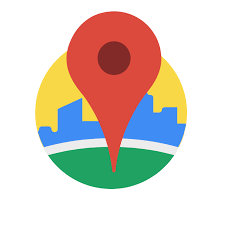

1) First the googlemaps library was added. Also in order to obtain better results in the location of coordinates directions variable was created.

In [8]:
import googlemaps
directions=toronto_df["PostalCode"]+ ", ONTARIO, CANADA"

2) The Google Cloud Secret Key was specified.

In [9]:
# The code was removed by Watson Studio for sharing.

3) Latitude and longitude were got from grocode API and added to the Toronto_Neighborhood Dataframe.

In [10]:
gmaps = googlemaps.Client(key=my_key)
i=len(directions)
lat=np.zeros(i)
long=np.zeros(i)
for j in range(i):
    direction=directions[j]
    geocode_result = gmaps.geocode(direction)
    lat[j]=geocode_result[0]["geometry"]["location"]["lat"]
    long[j]=geocode_result[0]["geometry"]["location"]["lng"]
toronto_df["Latitude"]=lat
toronto_df["Longitude"]=long

4) In the next cell is possible see the resultant dataframe from the code above.

In [11]:
toronto_df.sample(n=10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
96,M9L,North York,Humber Summit,43.756303,-79.565963
76,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
27,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923
25,M3A,North York,Parkwoods,43.753259,-79.329656
23,M2P,North York,York Mills West,43.752758,-79.400049
34,M4A,North York,Victoria Village,43.725882,-79.315572
67,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049
87,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558
17,M2H,North York,Hillcrest Village,43.803762,-79.363452


## 3. Get Veneus from Foursquare API

This section contains the steps followed to get venues from Foursquare in a properly way. Initially it was thought to work the parameters defined in the Segmenting and Clustering New York Neighborhoods I mean 500 meters of radius in every search. To not take risks this section has two parts:

1) Data exploration and refinement
2) Get Venues from Foursquare.


<img src="https://ss0.4sqi.net/img/developers/products/places-api-538e392a138bea16aa61260a55a875b4.png" width = 200>


#### 3.1. Data Exploration

1) Firstly a folium map was generated to understand the Toronto PostalCodes distribution.

In [12]:
address = 'Toronto, ONTARIO'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of TORONTO City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of TORONTO City are 43.653963, -79.387207.


In [13]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    
Toronto_map

2) The parameter used in New York Neighborhoods (radius=500 meters) was added to Toronto_map

In [14]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and radius to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=500,
        popup=label,
        location=[lat, lng],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(Toronto_map) 
Toronto_map

As the first Toronto Map shown, is confirmed in the map above that in many Postalcode a radius of 500 meters could left behind a lot of venue. Is possible identify a lot of Postalcode overlaping.
To solve the radius problem the GeoPy.Distance.greatCircle was used.

##### Additional Information about how get an properly radius:
Nearest Location:
https://stackoverflow.com/questions/49323171/find-the-nearest-location-using-numpy
Geopy.distance example:
https://www.programcreek.com/python/example/96855/geopy.distance.vincenty
Best way to compute distance:
https://geopy.readthedocs.io/en/stable/#module-geopy.distance


3) The Geopy.Distance.Greatcircle library was loaded and a function to find the nearest postalcode for each location was created.

In [15]:
from geopy.distance import great_circle
def find_closest_location(origin, locations):
    locations=np.asarray(locations)
    origin=np.asarray(origin).reshape(1,-1)
    i=len(locations)
    distances=np.zeros(i)
    for j in range(i):
        distances[j] = great_circle(origin, locations[j]).meters
    closest = np.argmin(distances)
    return [round(distances[closest]), closest]

Once the function was created a test was performed to know if the gottan data was correct.

In [16]:
locations=toronto_df[["Latitude", "Longitude"]]
meters, index=find_closest_location(locations[:1], locations[~locations.index.isin([0])])
close_point = locations[:1].append(locations[index+1:index+2])
points=np.asarray(close_point)
print("The distance between {} postalcode and the nearest neighbor ({} postalcode) is: {} meters".format(toronto_df["PostalCode"][0],toronto_df["PostalCode"][index+1], meters) )

The distance between M1B postalcode and the nearest neighbor (M1X postalcode) is: 3397.0 meters


In the output cell below is possible see a map that shows the results from the tested PostalCode above.
The tested PostalCode and its nearest neighbor was drawed in red and is possible locate them into the top right corner.

In [17]:
test_data=toronto_df
i=len(test_data)
tested=np.zeros(i)
tested[0]=1
tested[index+1]=1
tested=np.int64(tested)
test_data["Test"]=tested
colors = ["blue", "red"]
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers and radius to map
for lat, lng, borough, neighborhood, tested in zip(test_data['Latitude'], test_data['Longitude'], test_data['Borough'], test_data['PostalCode'], test_data["Test"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=None,
        fill=True,
        fill_color=colors[tested],
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)
folium.PolyLine(points, color="red", label = meters, weight=2.5, opacity=1).add_to(Toronto_map)
Toronto_map 


4) In order to get the radius computed from the distance to neares neighbor a iterate function was defined.

In [18]:
def get_radius(df, locations):
    for lat, lng, idx in zip(df['Latitude'], df['Longitude'], df.index):
        meters, index = find_closest_location([lat,lng], locations[~locations.index.isin([idx])])
        df.at[idx,'Radius'] = np.int64(meters//2) 
    return df

5) In the next steps a new dataframe with a new variable "Radius" was gotten.

In [19]:
df_4square=get_radius(toronto_df, locations)
df_4square.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Test,Radius
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0,1302.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,0,1113.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,0,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,0,1113.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0,1297.0


In [20]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and personalized radius to map
for lat, lng, borough, neighborhood, r in zip(df_4square['Latitude'], df_4square['Longitude'], df_4square['Borough'], df_4square['Neighborhood'], df_4square["Radius"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=r,
        popup=label,
        location=[lat, lng],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(Toronto_map) 
Toronto_map

In the deployed map above is easy to identify that the circles have better definition. 

#### 3.2 Get venues from Foursquare API

In the cells below the New York Lab code was replicated in order to get venues in every single postal code. After the venues data was collected a data preparation work was develop. Finally a venues dataframe is presented.

1) The new york lab function to get until 100 venues in the specified radius from all the PostaCodes in Toronto was defined.

In [21]:
def getNearbyVenues(ID, description, borough, latitudes, longitudes, radius):
    venues_list=[]
    for i, desc, b, lat, lng, r  in zip(ID, description, borough, latitudes, longitudes, radius ):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            r, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            i,
            desc,
            b,
            lat, 
            lng, 
            r,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',"Neighborhoods","Borough",'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  "PostalCode Radius",
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

2) Also the Foursquare API credentials, version and the highest number of venues was especified. 

In [22]:
# The code was removed by Watson Studio for sharing.

In [23]:
ID=df_4square["PostalCode"]
description=df_4square['Neighborhood']
borough=df_4square["Borough"]
latitudes=df_4square['Latitude']
longitudes=df_4square['Longitude']
radius=df_4square["Radius"]


In [24]:
venues = getNearbyVenues(ID, description, borough, latitudes, longitudes, radius)

In [25]:
venues.sample(n=5)

,PostalCode,Neighborhoods,Borough,PostalCode Latitude,PostalCode Longitude,PostalCode Radius,Venue,Venue Latitude,Venue Longitude,Venue Category
2668,M6P,"High Park, The Junction South",West Toronto,43.661608,-79.464763,781.0,Junction Flea,43.665258,-79.462868,Flea Market
1056,M4C,Woodbine Heights,East York,43.695344,-79.318389,702.0,Les Anthony Parkette,43.691387,-79.322940,Park
719,M2N,Willowdale South,North York,43.770120,-79.408493,1023.0,Cottage Restaurant,43.775572,-79.413234,Pizza Place
1066,M4E,The Beaches,East Toronto,43.676357,-79.293031,995.0,The Remarkable Bean,43.672801,-79.287038,Coffee Shop
2513,M6J,"Little Portugal, Trinity",West Toronto,43.647927,-79.419750,703.0,Drake Cafe,43.643061,-79.424820,Café


In [26]:
print("There are {} venues distributed on {} Categories.".format(venues.shape[0], venues["Venue Category"].unique().shape[0]))

There are 3324 venues distributed on 326 Categories.


In [27]:
# use the inline backend to generate the plots within the browser
 
import matplotlib as mpl
import matplotlib.pyplot as plt
print(plt.style.available)
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

['Solarize_Light2', '_classic_test', 'seaborn-dark', 'seaborn-talk', 'seaborn-darkgrid', 'ggplot', 'seaborn-pastel', 'classic', 'seaborn-muted', 'seaborn-ticks', 'seaborn-colorblind', 'seaborn-deep', 'seaborn-paper', 'seaborn-poster', 'fast', 'seaborn-whitegrid', 'fivethirtyeight', 'seaborn-white', 'grayscale', 'seaborn', 'seaborn-dark-palette', 'bmh', 'dark_background', 'seaborn-notebook', 'seaborn-bright']


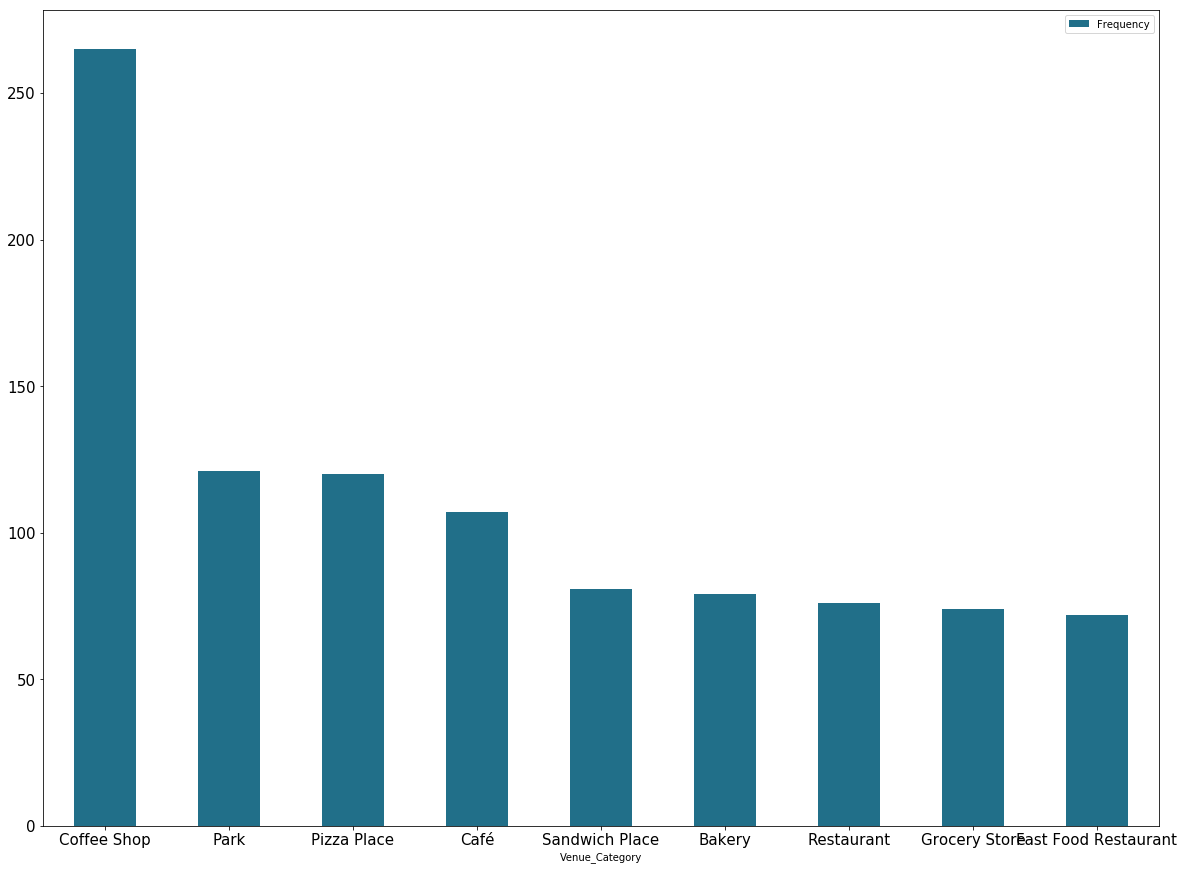

In [28]:
df_top10=df_top10=pd.DataFrame(venues['Venue Category'].value_counts()).reset_index(drop=False)[0:9]
df_top10.columns=["Venue_Category", "Frequency"]
x=df_top10.plot.bar(x="Venue_Category", y="Frequency", rot=0, figsize=(20,15), stacked=False, color="#216F89", fontsize=15)


In [29]:
print('Total Toronto postcodes:', df_4square['PostalCode'].shape[0])
print('Total Toronto postcodes with venues:', venues['PostalCode'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


In [30]:
No_venues = np.setdiff1d(df_4square['PostalCode'].values,venues['PostalCode'].unique())
df_4square[df_4square['PostalCode']==No_venues[0]]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Test,Radius
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,111.0


## 4. Cluster Neighborhoods